In [311]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import torch
import random


In [312]:
df = pd.read_csv("~/python_project/data/AI_dataset/data_by_states_20230518.csv")

In [313]:
#월별 & 주별 일조량 data 생성
sunlight = df[['ID', 'state', 'sunlight_svm']]

In [314]:
#모든 주 저장한 array
states = np.unique(df['state'].values)

In [315]:
onehot_enc = OneHotEncoder(sparse_output = False)

In [316]:
state_onehot = onehot_enc.fit_transform(sunlight['state'].values.reshape(-1,1))

In [317]:
sunlight_onehot = sunlight.drop(columns = "state")

In [319]:
for i, state in enumerate(onehot_enc.categories_[0]):
    sunlight_onehot[state] = state_onehot.T[i]

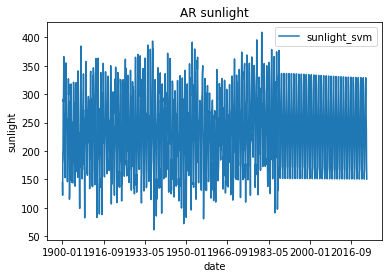

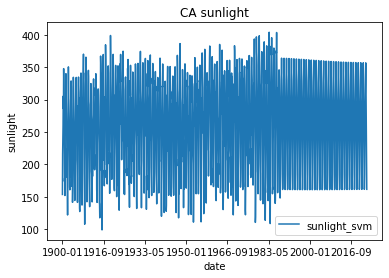

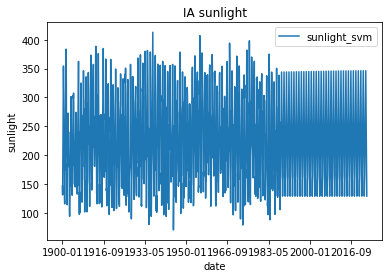

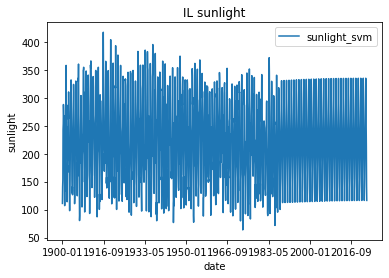

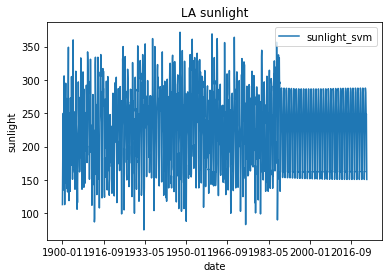

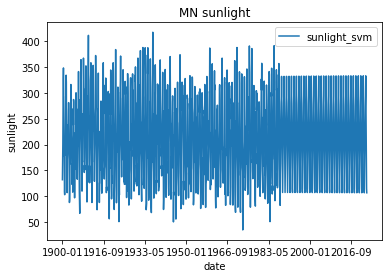

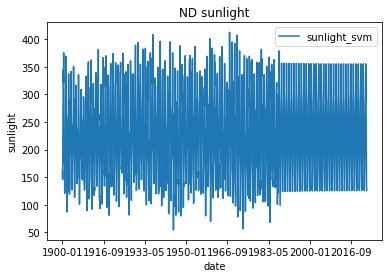

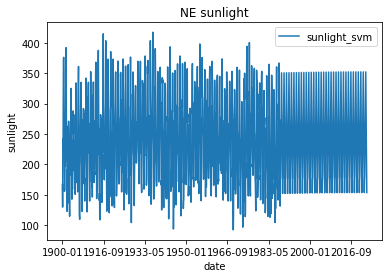

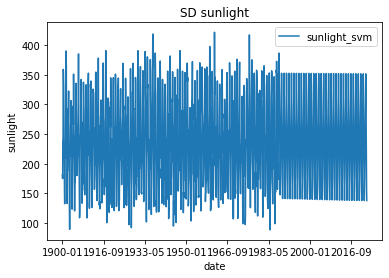

In [320]:
#x축 ID(1900-01 ~ 2022-12), y축이 일조량인 그래프 생성
for state in states:
    sunlight[sunlight['state'] == state].set_index(sunlight[sunlight['state'] == state]['ID']).plot()    
    plt.xlabel('date')
    plt.ylabel('sunlight')
    plt.title(state + " sunlight")
    plt.show()

In [321]:
#ID를 연, 월로 분리하고 int로 형변환해 [연, 월] 형태의 리스트 생성
date_strings = np.array([date.split('-') for date in sunlight['ID']])
dates = []
for date_string in date_strings:
    date = [int(val) for val in date_string]
    dates.append(date)

In [322]:
sunlight_onehot['Year'] = np.array(dates).T[0]
sunlight_onehot['Month'] = np.array(dates).T[1]

In [323]:
sunlight_onehot = sunlight_onehot.drop(columns = 'ID')

In [324]:
sunlight_onehot = sunlight_onehot[['Year', 'Month', 'AR', 'CA', 'IA', 'IL', 'LA', 'MN', 'ND', 'NE', 'SD', 'sunlight_svm']]

In [408]:
sunlight_onehot.columns.tolist()

['Year',
 'Month',
 'AR',
 'CA',
 'IA',
 'IL',
 'LA',
 'MN',
 'ND',
 'NE',
 'SD',
 'sunlight_svm']

In [413]:
states_dict = {state:i for i, state in enumerate(sunlight_onehot.columns.tolist())}

In [441]:
#input: 연 월, output(target): 일조량
X = sunlight_onehot.drop(columns = 'sunlight_svm').values.astype(int)
y = sunlight_onehot['sunlight_svm'].values

In [541]:
#원하는 sequence만큼 data를 이어줌 (num_data,sequence_length, input_size)형태)
def data_to_seq(X, y, input_size, seq_length):
    X_seq = np.array([])
    y_seq = np.array([])
    i = 0
    while i < X.shape[0] - (seq_length - 1):
        if X[i + seq_length - 1][0] == 0 and X[i + seq_length - 1][1] == 0 and X[i + seq_length - 1][2] == 0 and seq_length != 1:
            i += (seq_length - 1)
        else:
            X_seq = np.append(X_seq, X[i:i + seq_length])
            y_seq = np.append(y_seq, y[i + seq_length - 1])
            i += 1
    return X_seq.reshape(-1, seq_length, input_size), y_seq

In [453]:
#input dimesion과 batch size, sequence 길이 설정
seq_length = 12
input_size = X.shape[1]
batch_size = 4

In [454]:
#Minmax scaler를 통해 normalize
#나올 수 있는 모든 값들이 random하게 선택되었다는 가정하에 전체 데이터셋에 대하여 scaling 진행
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [542]:
#input data를 sequential하게 이어줌
X_seq, y_seq = data_to_seq(X = X_scaled, y = y, input_size = input_size,seq_length = seq_length)

In [380]:
#train, test set 분리
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size = 0.2, random_state = 0)

In [381]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [382]:
train = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train, batch_size = batch_size, shuffle=True)

test = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test, batch_size = batch_size, shuffle=False)

In [383]:
#LSTM
class LSTM_model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )

        self.fc = torch.nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x = x.to(device)
        y, hidden = self.lstm(x)
        y = y[:,-1,:]
        y = self.fc(y)
        return y.view(-1)

In [384]:
#RNN
class RNN_model(torch.nn.Module):
    def __init__(self,input_size, hidden_size, output_size, num_layers):
        super(RNN_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.rnn_layer = torch.nn.RNN(
            input_size = self.input_size,
            hidden_size = self.hidden_size, 
            num_layers = self.num_layers, 
            batch_first = True)
        self.fc = torch.nn.Linear(hidden_size, output_size) 
    def forward(self,x):
        x = x.to(device)
        y, hidden = self.rnn_layer(x)
        y = y[:,-1, :]
        y = self.fc(y)
        return y.view(-1)

In [385]:
#GRU
class GRU_model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRU_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.gru = torch.nn.GRU(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )

        self.fc = torch.nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x = x.to(device)
        y, hidden = self.gru(x)
        y = y[:,-1,:]
        y = self.fc(y)
        return y.view(-1)


In [386]:
#training
def train(model, dataloader, loss_fn, optim, epochs, device):
    model.train()
    num_batch = len(dataloader)
    for epoch in range(1, epochs + 1):
        train_loss = 0
        for x, y_true in dataloader:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = model(x)
            loss = loss_fn(y_true, y_pred)
            train_loss += loss.item()
            optim.zero_grad()
            loss.backward()
            optim.step()
        train_loss /= num_batch
        if epoch % 20 == 0:
            print(f'Epoch: {epoch}, Train Loss: {train_loss:.8f}')
    return train_loss

In [387]:
#test
def validation(model, dataloader, loss_fn, device):
    model.eval()
    val_loss = 0
    num_batch = len(dataloader)
    with torch.no_grad():
        for x, y_true  in dataloader:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = model(x)
            loss = loss_fn(y_true, y_pred)
            val_loss += loss.item()
    val_loss /= num_batch
    return val_loss

In [388]:
#learning late, hidden size, layer 수, output dimesion, epoch, device 설정
lr = 0.001
hidden_size = 10
num_layers = 1
output_size = 1
epochs = 300
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [389]:
#RNN 모델
model_1 = RNN_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_1 = torch.nn.MSELoss().to(device)
optim_1 = torch.optim.Adam(params=model_1.parameters(), lr = lr )


In [390]:
#LSTM 모델
model_2 = LSTM_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_2 = torch.nn.MSELoss().to(device)
optim_2 = torch.optim.Adam(params=model_2.parameters(), lr = lr )

In [391]:
#GRU 모델
model_3 = GRU_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_3 = torch.nn.MSELoss().to(device)
optim_3 = torch.optim.Adam(params=model_3.parameters(), lr = lr )

In [392]:
#RNN 모델 training
train(model = model_1, dataloader = train_dataloader, loss_fn = loss_func_1, optim = optim_1, epochs = epochs, device = device)

Epoch: 20, Train Loss: 4152.65556472
Epoch: 40, Train Loss: 854.95701574
Epoch: 60, Train Loss: 826.00791338
Epoch: 80, Train Loss: 813.27365939
Epoch: 100, Train Loss: 809.43846253
Epoch: 120, Train Loss: 801.66511850
Epoch: 140, Train Loss: 797.32619908
Epoch: 160, Train Loss: 795.69741339
Epoch: 180, Train Loss: 791.32872822
Epoch: 200, Train Loss: 791.66197412
Epoch: 220, Train Loss: 789.31046670
Epoch: 240, Train Loss: 789.92381526
Epoch: 260, Train Loss: 786.89259411
Epoch: 280, Train Loss: 786.93605652
Epoch: 300, Train Loss: 786.37698007


786.3769800737585

In [393]:
#LSTM 모델 training
train(model = model_2, dataloader = train_dataloader, loss_fn = loss_func_2, optim = optim_2, epochs = epochs, device = device)

Epoch: 20, Train Loss: 941.49457657
Epoch: 40, Train Loss: 802.61710476
Epoch: 60, Train Loss: 784.74953286
Epoch: 80, Train Loss: 771.42936301
Epoch: 100, Train Loss: 767.66835694
Epoch: 120, Train Loss: 762.70256206
Epoch: 140, Train Loss: 758.92986463
Epoch: 160, Train Loss: 754.08326822
Epoch: 180, Train Loss: 750.79768411
Epoch: 200, Train Loss: 746.76728113
Epoch: 220, Train Loss: 744.70539512
Epoch: 240, Train Loss: 740.90934674
Epoch: 260, Train Loss: 737.80003744
Epoch: 280, Train Loss: 736.35080461
Epoch: 300, Train Loss: 734.10189967


734.1018996741403

In [394]:
#GRU 모델 training
train(model = model_3, dataloader = train_dataloader, loss_fn = loss_func_3, optim = optim_3, epochs = epochs, device = device)

Epoch: 20, Train Loss: 1597.73211890
Epoch: 40, Train Loss: 818.04263484
Epoch: 60, Train Loss: 793.90922654
Epoch: 80, Train Loss: 784.96151734
Epoch: 100, Train Loss: 780.20194923
Epoch: 120, Train Loss: 770.68805958
Epoch: 140, Train Loss: 769.58418938
Epoch: 160, Train Loss: 767.31868362
Epoch: 180, Train Loss: 766.68801383
Epoch: 200, Train Loss: 762.72478949
Epoch: 220, Train Loss: 762.49468864
Epoch: 240, Train Loss: 759.10500184
Epoch: 260, Train Loss: 755.98784855
Epoch: 280, Train Loss: 755.29075625
Epoch: 300, Train Loss: 757.21500810


757.2150080974553

In [395]:
#RNN 모델 test loss
validation(model_1, test_dataloader, loss_func_1, device)

827.2221392617081

In [396]:
#LSTM 모델 test loss
validation(model_2, test_dataloader, loss_func_2, device)

793.8060405713139

In [397]:
#GRU 모델 test loss
validation(model_3, test_dataloader, loss_func_3, device)

803.7281189227307

In [415]:
states_dict

{'Year': 0,
 'Month': 1,
 'AR': 2,
 'CA': 3,
 'IA': 4,
 'IL': 5,
 'LA': 6,
 'MN': 7,
 'ND': 8,
 'NE': 9,
 'SD': 10,
 'sunlight_svm': 11}

In [425]:
len(X_seq)

13185

In [426]:
len(X)

13284

In [437]:
X_scaled[0][0] == 0.0

True

In [493]:
sunlight['sunlight_svm'].values

array([144.       , 122.       , 194.       , ..., 215.8733655,
       156.8504756, 137.9327527])

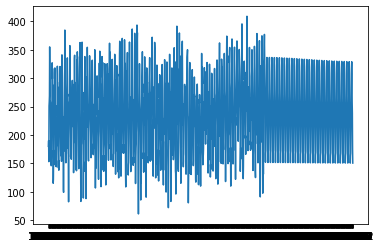

In [495]:
plt.plot(np.unique(sunlight.ID.values)[seq_length - 1:], sunlight[sunlight['state'] == state]['sunlight_svm'][seq_length -1:].values)
plt.show()

In [553]:
#주별로 처음 시작하는 index저장
start_idx_for_state = np.array([(len(X_seq) / len(states)) * i for i in range (0, len(states))])

In [554]:
start_idx_for_state = start_idx_for_state.astype(int)

In [498]:
model_1(torch.FloatTensor(X_seq[start_idx_for_state[1 - 1]:start_idx_for_state[1]])).cpu().detach().numpy().shape

(1476,)

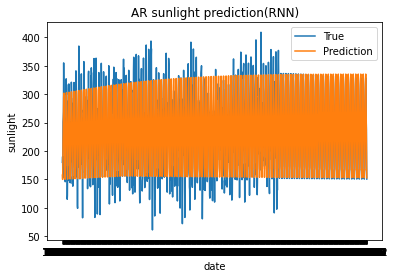

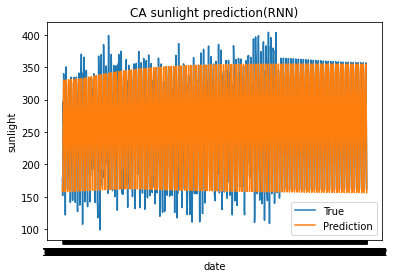

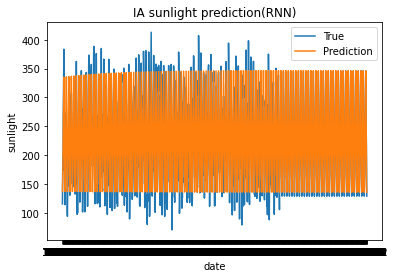

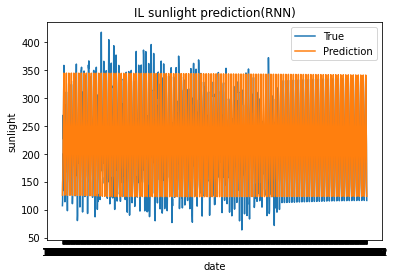

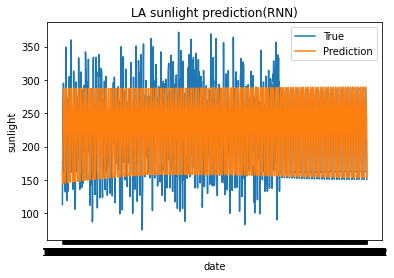

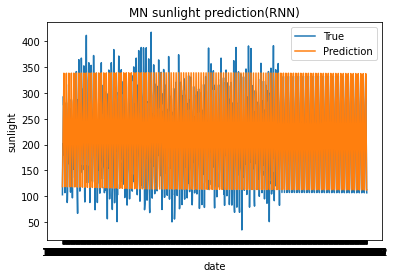

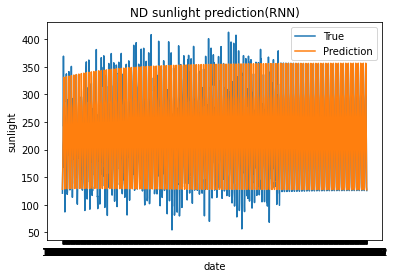

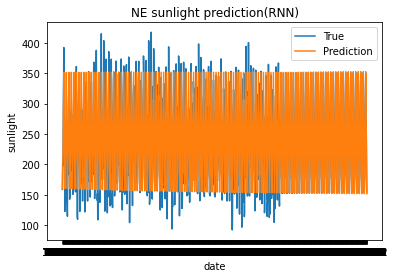

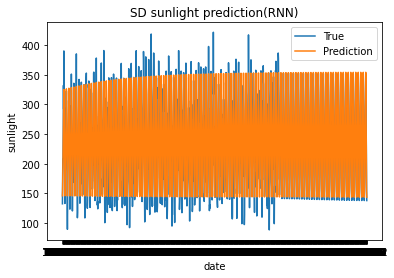

In [557]:
#x축 date(1900-01 ~ 2022-12) y축 일조량인 true값 그래프와 RNN모델 예측값 그래프 생성
for i, state in enumerate(states):
    plt.plot(np.unique(sunlight.ID.values)[seq_length - 1:], sunlight[sunlight['state'] == state]['sunlight_svm'][seq_length -1:].values, label = 'True')    
    if i != (len(states) - 1):
        plt.plot(np.unique(sunlight.ID.values)[seq_length - 1:], model_1(torch.FloatTensor(X_seq[start_idx_for_state[i]:start_idx_for_state[i + 1]])).cpu().detach().numpy(), label = 'Prediction')
    else:
        plt.plot(np.unique(sunlight.ID.values)[seq_length - 1:], model_1(torch.FloatTensor(X_seq[start_idx_for_state[i]:])).cpu().detach().numpy(), label = 'Prediction')
    plt.xlabel('date')
    plt.ylabel('sunlight')
    plt.title(state + " sunlight prediction(RNN)")
    plt.legend()
    plt.show()

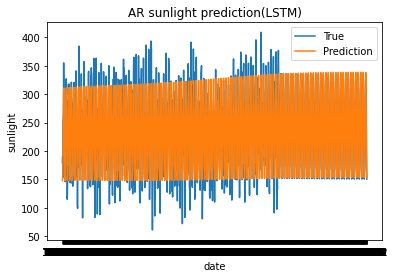

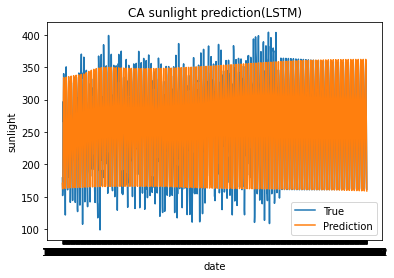

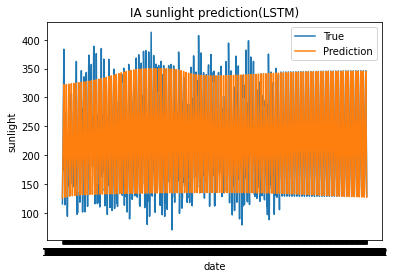

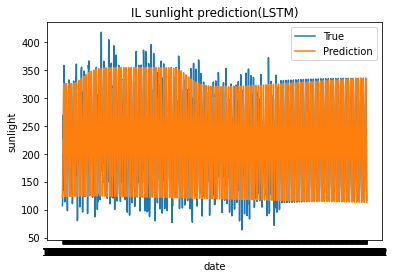

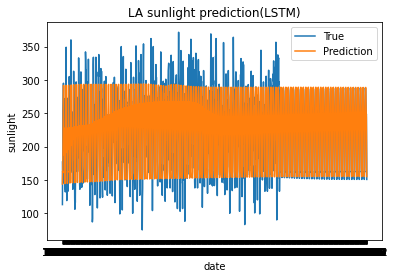

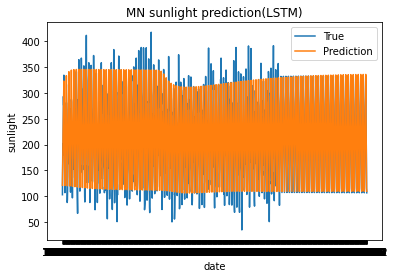

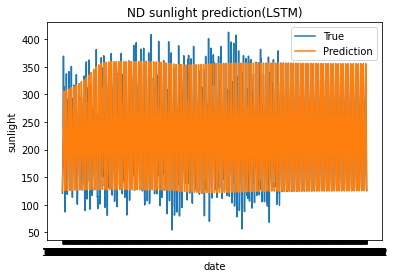

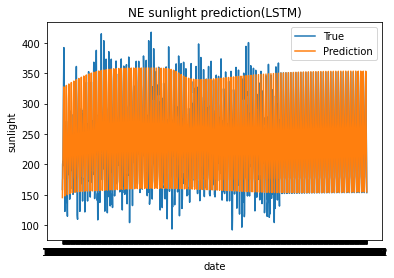

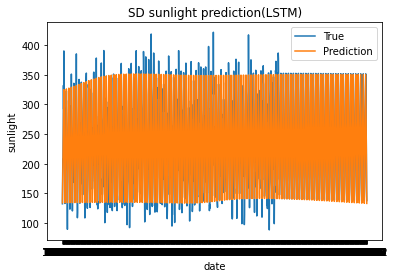

In [558]:
#x축 date(1900-01 ~ 2022-12) y축 일조량인 true값 그래프와 LSTM모델 예측값 그래프 생성
for i, state in enumerate(states):
    plt.plot(np.unique(sunlight.ID.values)[seq_length - 1:], sunlight[sunlight['state'] == state]['sunlight_svm'][seq_length -1:].values, label = 'True')    
    if i != (len(states) - 1):
        plt.plot(np.unique(sunlight.ID.values)[seq_length - 1:], model_2(torch.FloatTensor(X_seq[start_idx_for_state[i]:start_idx_for_state[i + 1]])).cpu().detach().numpy(), label = 'Prediction')
    else:
        plt.plot(np.unique(sunlight.ID.values)[seq_length - 1:], model_2(torch.FloatTensor(X_seq[start_idx_for_state[i]:])).cpu().detach().numpy(), label = 'Prediction')
    plt.xlabel('date')
    plt.ylabel('sunlight')
    plt.title(state + " sunlight prediction(LSTM)")
    plt.legend()
    plt.show()

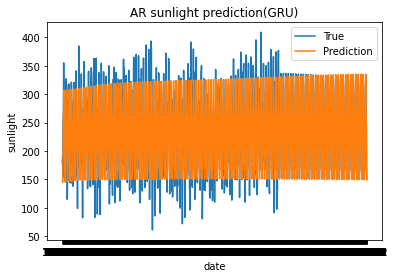

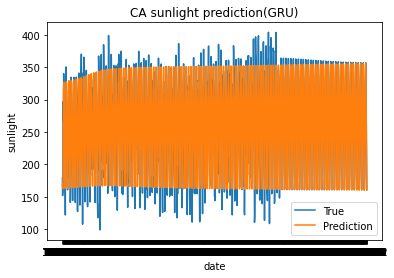

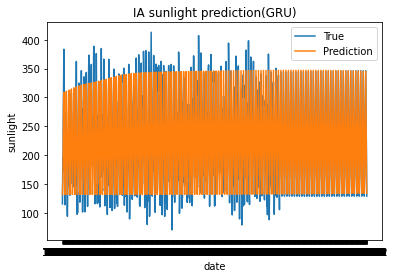

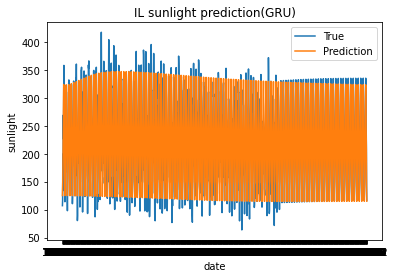

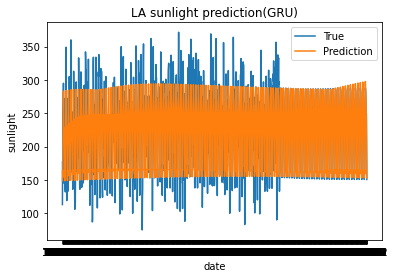

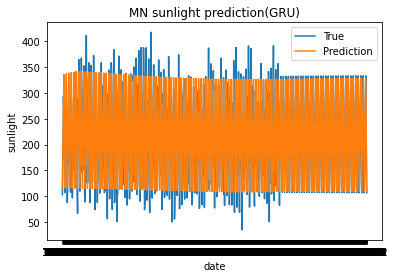

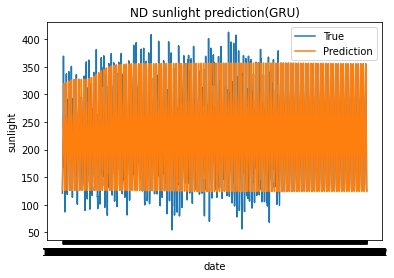

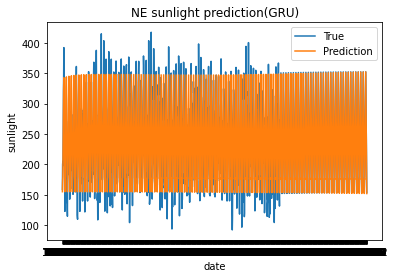

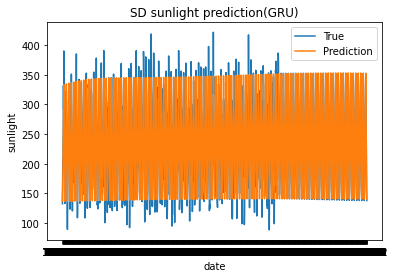

In [559]:
#x축 date(1900-01 ~ 2022-12) y축 일조량인 true값 그래프와 GRU모델 예측값 그래프 생성
for i, state in enumerate(states):
    plt.plot(np.unique(sunlight.ID.values)[seq_length - 1:], sunlight[sunlight['state'] == state]['sunlight_svm'][seq_length -1:].values, label = 'True')    
    if i != (len(states) - 1):
        plt.plot(np.unique(sunlight.ID.values)[seq_length - 1:], model_3(torch.FloatTensor(X_seq[start_idx_for_state[i]:start_idx_for_state[i + 1]])).cpu().detach().numpy(), label = 'Prediction')
    else:
        plt.plot(np.unique(sunlight.ID.values)[seq_length - 1:], model_3(torch.FloatTensor(X_seq[start_idx_for_state[i]:])).cpu().detach().numpy(), label = 'Prediction')
    plt.xlabel('date')
    plt.ylabel('sunlight')
    plt.title(state + " sunlight prediction(GRU)")
    plt.legend()
    plt.show()

In [398]:
#RNN, LSTM, GRU을 ensemble한 model
class EnsembleModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(EnsembleModel, self).__init__()
        self.gru_model = GRU_model(input_size, hidden_size, output_size, num_layers)
        self.rnn_model = RNN_model(input_size, hidden_size, output_size, num_layers)
        self.lstm_model = LSTM_model(input_size, hidden_size, output_size, num_layers)

    def forward(self, x):
        x= x.to(device)
        output_gru = self.gru_model(x)
        output_rnn = self.rnn_model(x)
        output_lstm = self.lstm_model(x)

        output = torch.mean(torch.Floattensor(output_rnn,output_gru, output_lstm))

        return output

In [399]:
#LSTM, GRU을 ensemble한 model
class EnsembleModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(EnsembleModel, self).__init__()
        self.gru_model = GRU_model(input_size, hidden_size, output_size, num_layers)
        self.lstm_model = LSTM_model(input_size, hidden_size, output_size, num_layers)

    def forward(self, x):
        x= x.to(device)
        output_gru = self.gru_model(x)
        output_lstm = self.lstm_model(x)

        output = torch.mean(torch.Floattensor(output_gru, output_lstm))

        return output

In [400]:
#Ensemble(RNN, LSTM, GRU)
model_4 = GRU_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_4 = torch.nn.MSELoss().to(device)
optim_4 = torch.optim.Adam(params=model_4.parameters(), lr = lr )

In [401]:
#Ensemble(RNN, LSTM, GRU) 모델 training
train(model = model_4, dataloader = train_dataloader, loss_fn = loss_func_4, optim = optim_4, epochs = epochs, device = device)

Epoch: 20, Train Loss: 2978.50119705
Epoch: 40, Train Loss: 836.74877353
Epoch: 60, Train Loss: 796.26572643
Epoch: 80, Train Loss: 790.70200915
Epoch: 100, Train Loss: 786.72665260
Epoch: 120, Train Loss: 777.99935769
Epoch: 140, Train Loss: 773.84578245
Epoch: 160, Train Loss: 773.60874404
Epoch: 180, Train Loss: 772.92360580
Epoch: 200, Train Loss: 768.07621084
Epoch: 220, Train Loss: 763.84941450
Epoch: 240, Train Loss: 765.11642576
Epoch: 260, Train Loss: 762.97048811
Epoch: 280, Train Loss: 761.38931848
Epoch: 300, Train Loss: 758.71558610


758.7155860968508

In [402]:
#Ensemble(RNN, LSTM, GRU) 모델 test loss
validation(model_4, test_dataloader, loss_func_4, device)

787.46985021071

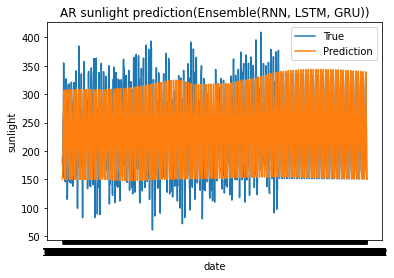

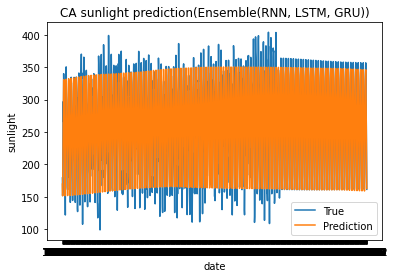

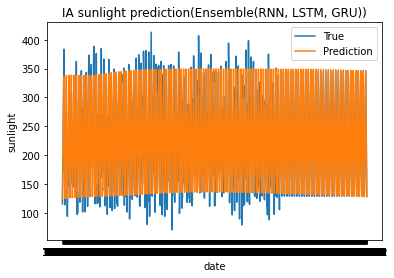

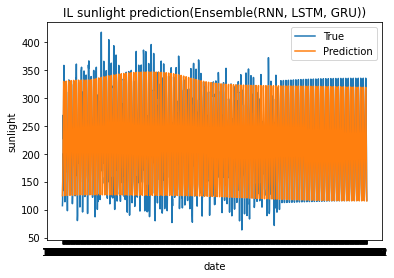

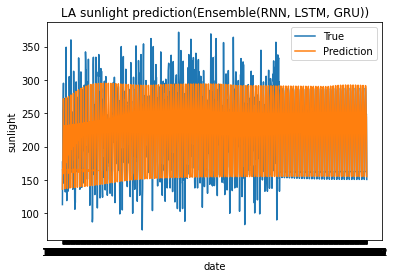

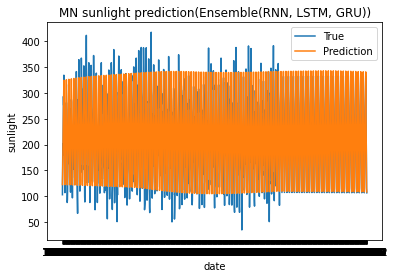

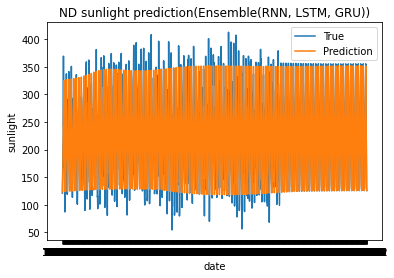

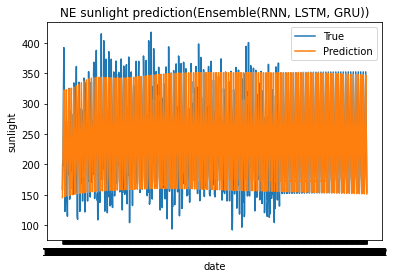

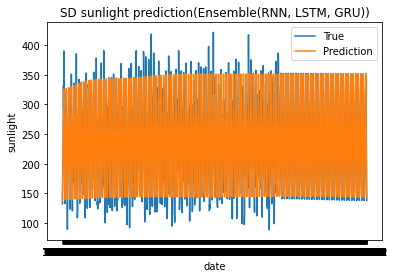

In [560]:
#x축 date(1900-01 ~ 2022-12) y축 일조량인 true값 그래프와 Ensemble모델(RNN, LSTM, GRU) 예측값 그래프 생성
for i, state in enumerate(states):
    plt.plot(np.unique(sunlight.ID.values)[seq_length - 1:], sunlight[sunlight['state'] == state]['sunlight_svm'][seq_length -1:].values, label = 'True')    
    if i != (len(states) - 1):
        plt.plot(np.unique(sunlight.ID.values)[seq_length - 1:], model_4(torch.FloatTensor(X_seq[start_idx_for_state[i]:start_idx_for_state[i + 1]])).cpu().detach().numpy(), label = 'Prediction')
    else:
        plt.plot(np.unique(sunlight.ID.values)[seq_length - 1:], model_4(torch.FloatTensor(X_seq[start_idx_for_state[i]:])).cpu().detach().numpy(), label = 'Prediction')
    plt.xlabel('date')
    plt.ylabel('sunlight')
    plt.title(state + " sunlight prediction(Ensemble(RNN, LSTM, GRU))")
    plt.legend()
    plt.show()

In [403]:
#Ensemble(LSTM, GRU)
model_5 = GRU_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_5 = torch.nn.MSELoss().to(device)
optim_5 = torch.optim.Adam(params=model_5.parameters(), lr = lr )

In [404]:
#Ensemble(LSTM, GRU) 모델 training
train(model = model_5, dataloader = train_dataloader, loss_fn = loss_func_5, optim = optim_5, epochs = epochs, device = device)

Epoch: 20, Train Loss: 4135.71317336
Epoch: 40, Train Loss: 4128.28277004
Epoch: 60, Train Loss: 843.41091713
Epoch: 80, Train Loss: 798.59885982
Epoch: 100, Train Loss: 786.08528205
Epoch: 120, Train Loss: 776.47983854
Epoch: 140, Train Loss: 772.17713788
Epoch: 160, Train Loss: 770.47999572
Epoch: 180, Train Loss: 766.25554509
Epoch: 200, Train Loss: 765.17687645
Epoch: 220, Train Loss: 765.70627534
Epoch: 240, Train Loss: 767.10849969
Epoch: 260, Train Loss: 760.39512138
Epoch: 280, Train Loss: 758.48700718
Epoch: 300, Train Loss: 755.64160610


755.6416060984881

In [406]:
#Ensemble(LSTM, GRU) 모델 test loss
validation(model_5, test_dataloader, loss_func_5, device)

800.4014174497489

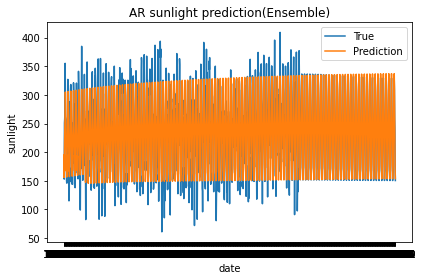

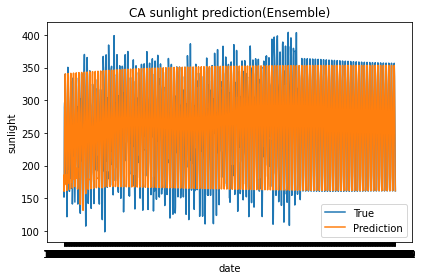

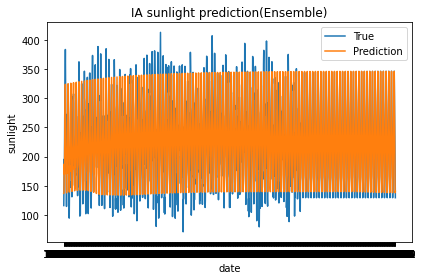

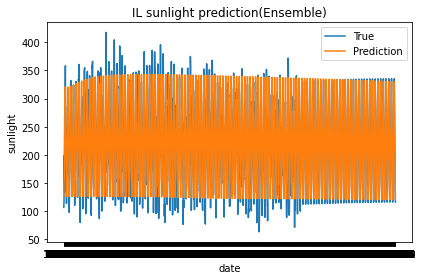

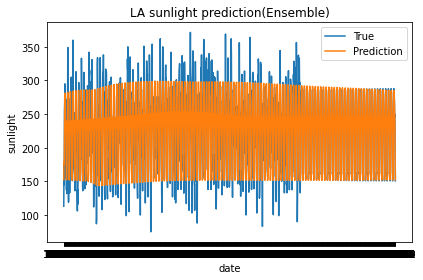

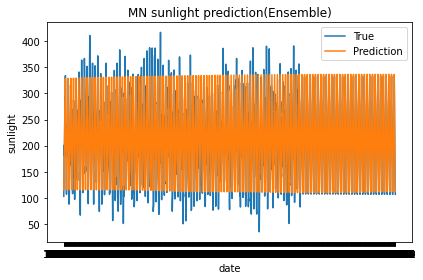

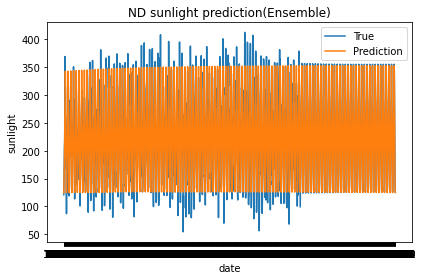

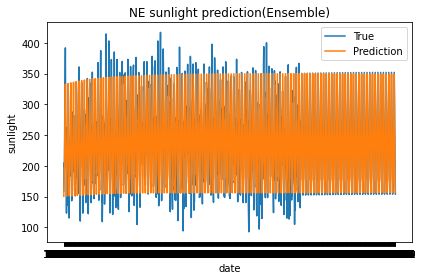

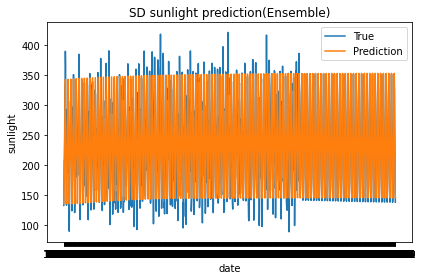

In [561]:
#x축 date(1900-01 ~ 2022-12) y축 일조량인 true값 그래프와 Ensemble모델(LSTM, GRU) 예측값 그래프 생성
for i, state in enumerate(states):
    plt.plot(np.unique(sunlight.ID.values)[seq_length - 1:], sunlight[sunlight['state'] == state]['sunlight_svm'][seq_length -1:].values, label = 'True')    
    if i != (len(states) - 1):
        plt.plot(np.unique(sunlight.ID.values)[seq_length - 1:], model_5(torch.FloatTensor(X_seq[start_idx_for_state[i]:start_idx_for_state[i + 1]])).cpu().detach().numpy(), label = 'Prediction')
    else:
        plt.plot(np.unique(sunlight.ID.values)[seq_length - 1:], model_5(torch.FloatTensor(X_seq[start_idx_for_state[i]:])).cpu().detach().numpy(), label = 'Prediction')
    plt.xlabel('date')
    plt.ylabel('sunlight')
    plt.title(state + " sunlight prediction(Ensemble)")
    plt.legend()
    plt.show()

In [589]:
test_loss = [validation(model_1, test_dataloader, loss_func_1, device),
            validation(model_2, test_dataloader, loss_func_2, device),
            validation(model_3, test_dataloader, loss_func_3, device),
            validation(model_4, test_dataloader, loss_func_4, device),
            validation(model_5, test_dataloader, loss_func_5, device)]

In [590]:
model_name = ["RNN", "LSTM", "GRU", "Ensemble(RNN, LSTM, GRU)", "Ensemble(LSTM, GRU)"]

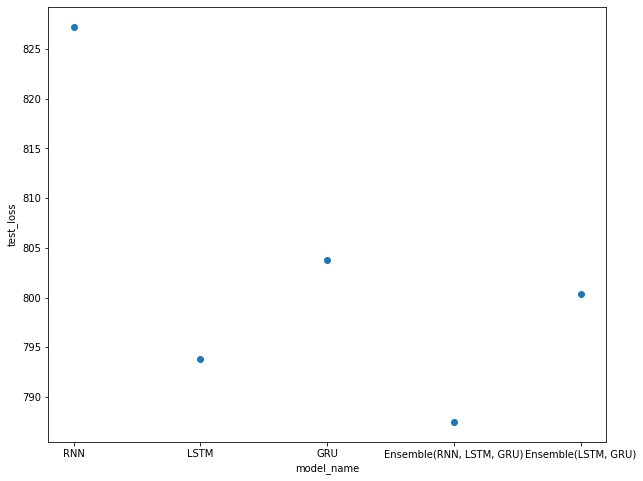

In [598]:
#model별 test loss를 plot
plt.figure(figsize=(10,8))
plt.scatter(model_name, test_loss)
plt.xlabel("model_name")
plt.ylabel("test_loss")
plt.show()

In [656]:
#모델예측을 위한 연,월 및 주 데이터 생성
#지금 seq_length가 12이므로 1월부터~12월까지의 데이터를 이용해 12월의 일조량 예측하므로 2022년 데이터까지 사용
X_2022_to_2032 = np.array([])
for state in range(0, len(states)):
    state_list = np.zeros(len(states), dtype = int)
    state_list[state] = 1
    for year in range(2022, 2032 + 1):
        for month in range(1, 13):
            tmp = np.concatenate((np.array([year, month]), state_list))
            X_2022_to_2032 = np.append(X_2022_to_2032, tmp)

In [657]:
X_2022_to_2032 = X_2022_to_2032.reshape(-1, 11).astype(int)

In [659]:
#데이터 스케일링
X_2022_to_2032_scaled = scaler.transform(X_2022_to_2032)

In [606]:
#데이터를 sequence length만큼 이어주는 함수
def data_to_seq_x(X, input_size, seq_length):
    X_seq = np.array([])
    i = 0
    while i < X.shape[0] - (seq_length - 1):
        if X[i + seq_length - 1][0] == 0 and X[i + seq_length - 1][1] == 0 and X[i + seq_length - 1][2] == 0 and seq_length != 1:
            i += (seq_length - 1)
        else:
            X_seq = np.append(X_seq, X[i:i + seq_length])
            i += 1
    return X_seq.reshape(-1, seq_length, input_size)

In [667]:
X_2022_to_2032_scaled_seq = data_to_seq_x(X_2022_to_2032_scaled, X_2022_to_2032_scaled.shape[1], seq_length)

In [678]:
#일조량 예측값
#2022년 1~12월 데이터로 12월 일조량 예측한게 첫 예측값이므로 나머지 22년 1월부터 11월까지는 0으로채움(어차피 2023년 데이터부터 쓸것이므로)
#4번째 모델(Ensemble(RNN, LSTM, GRU)의 test loss가 가장 작으므로 4번째 모델로 예측
sunlight_2022_to_2032 = np.concatenate((np.zeros(11),model_4(torch.FloatTensor(X_2022_to_2032_scaled_seq)).cpu().detach().numpy()))

In [688]:
#input데이터와 output데이터 합침
pred_2022_to_2032 = pd.DataFrame(np.hstack((X_2022_to_2032, sunlight_2022_to_2032.reshape(-1,1))), columns = sunlight_onehot.columns)

In [690]:
#일조량 제외 나머지 column int로 형변환
for column in pred_2022_to_2032.columns:
    if column == "sunlight_svm":
        pass
    else:
        pred_2022_to_2032 = pred_2022_to_2032.astype({column:int})

In [692]:
#2022년 data drop
pred_2022_to_2032 = pred_2022_to_2032 .drop(pred_2022_to_2032[pred_2022_to_2032 ['Year'] == 2022].index)

In [703]:
#연, 월 column으로 id column 생성
pred_2022_to_2032['ID'] = pred_2022_to_2032['Year'].astype(str) + '-' + pred_2022_to_2032['Month'].apply(lambda x: str(x).zfill(2))

In [709]:
pred_2022_to_2032.drop(columns = ['Year', 'Month']).to_csv("sunlight_2023_to_2032.csv")